In [1]:
### IMPORTS ###
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from msr_utils import *
import time

In [ ]:
### GMRES UTILS ###

precond_dict = {
    0: "No preconditioning",
    1: "Jacobian preconditioning",
    2: "Gauss-Seidel preconditioning",
    3: "ILU(0) preconditioning",
}

def getGivens(upper, lower): # Returns cos and sin values of a right triangle.
    hypo = np.sqrt(upper*upper + lower*lower)
    return (upper/hypo, lower/hypo)

def getKrylov(JM, VM, precond, P, V, H, j):
    if (precond == 0):
        w = msrmul(JM, VM, V[:,j])
    else:
        PJM, PVM = P
        w = msrmul(PJM, PVM, msrmul(JM, VM, V[:,j]))

    for i in range(j+1):
        H[i,j] = dot(V[:,i],w)
        w = w - H[i,j] * V[:,i]        
    H[j+1,j] = norm(w)
    V[:,j+1] = w / (H[j+1,j])

In [6]:
### FULL GMRES ALGORITHM ###

def fullGMRES(JM, VM, x0, b, precond, P, m=100, tol=1e-08):
    n = len(b)
    H = np.zeros((m+1,m)) # Complete Hessenberg is created here, because appending vectors to a matrix is much slower than having the entire matrix prepared as a placeholder firsthand.
    V = np.zeros((n,m+1)) # Also for V. I chose this method because the program never exceeded 1 GB of ram.
    e1 = np.zeros(m+1)
    e1[0] = 1
    
    if (precond == 0):
        r0 = (b - msrmul(JM, VM, x0))
    else:
        PJM, PVM = P
        r0 = msrmul(PJM, PVM, b - msrmul(JM, VM, x0))
 
    beta = norm(r0)
    V[:,0] = r0 / beta
    g = beta*e1
    c = np.zeros(m)
    s = np.zeros(m)
    ros = np.zeros(m)

    for j in range(m):
        getKrylov(JM, VM, precond, P, V, H, j)
        for k in range(j):
            k += 1
            temp = c[k-1]*H[k-1,j] + s[k-1]*H[k,j]
            H[k,j] = -s[k-1]*H[k-1,j] + c[k-1]*H[k,j]
            H[k-1,j] = temp
        c[j], s[j] = getGivens(H[j,j], H[j+1,j])
        H[j,j] = c[j] * H[j,j] + s[j] * H[j+1,j]
        g[j+1] = -s[j]*g[j]
        g[j] = c[j]*g[j]
        rel_ro = np.abs(g[j+1]) / beta
        ros[j] = rel_ro
        print("[@ Krylov-Space:",j+1,"] Error =", np.abs(g[j+1]), "Relative residual =", rel_ro)
        if rel_ro <= tol: 
            print("Converged at inner iteration:", j+1, "(A dimension:", n,")")
            break
        
    m_hat = min(m,j+1)
    m = m_hat
    Rm = [H[i,j] if i <= j else 0 for i in range(m) for j in range(m)]
    Rm = np.reshape(Rm, (m,m))
    y_star = back_sub(Rm, g[:m])
    xm = x0 + matvecmul(V[:,:m], y_star)
    return (xm, np.abs(g[j+1]), ros[:m], V[:,:m])


In [7]:
### RESTARTED GMRES ###
### !!! WARNING: Construction of GS and ILU0 preconditioners are not in msr format, hence can take some time. (~5mins, ~20mins)

def GMRES(JM, VM, x0, b, precond = 0, m=100, tol=1e-08, maxit=600):
    """
    Restarted GMRES Algorithm.

    :param JM: Column/index vector of MSR.
    :param VM: Value vector of MSR.
    :param x0: Initial guess.
    :param b: Target/result.
    :param precond: Preconditioner method. Available int args: {0:No preconditioning(default), 1: Jacobian, 2: Gauss-Seidel, 3: ILU0}.
    :param m: Krylov-Space dimensions.
    :param tol: Tolerance of acceptable convergence.
    :param maxit: Maximum amount of iterations without convergence.
    :return: Returns converged solution, absolute error, relative error, execution time, and V matrix of Krylov Space.
    """
    dim = len(x0)
    
    print(precond_dict[precond], "selected.")
    if (precond == 1): # Jacobi preconditioner. Diagonal of the model matrix.
        P = np.diag(1/(VM[0:dim]+1e-25)) 
        PJM, PVM = to_msr(P)
        P = (PJM, PVM)
    elif (precond == 2): # Gauss-Seidal preconditioning.
        M = np.zeros((dim,dim))
        I = np.eye(dim)
        for j in range(dim):
            M[:,j] = msrmul(JM, VM, I[:,j])
        P = forth_sub_inv(M) # Inverting M
        PJM, PVM = to_msr(P)
        P = (PJM, PVM)
    elif (precond == 3): # ILU preconditioning.
        M = np.zeros((dim,dim))
        I = np.eye(dim)
        print("Constructing M...")
        for j in range(dim):
            M[:,j] = msrmul(JM, VM, I[:,j])
        print("Decomposing into ILU0...")
        L, U = ILU0(M)
        print("Calculating L inverse...")
        L_inv = forth_sub_inv(L)
        print("Calculating U inverse...")
        U_inv = back_sub_inv(U)
        print("Constructing preconditioner...")
        P = matmul(L_inv, U_inv)
        # np.save("ILU0preconditioner.npy", P)
        # P = np.load("ILU0preconditioner.npy")
        PJM, PVM = to_msr(P)
        P = (PJM, PVM)
    else:
        P = None

    x = x0
    r0 = b - msrmul(JM, VM, x)
    absro = norm(r0)
    i = 0
    start = time.time()
    while absro > tol:
        print("Outer iteration:", i+1, "......")
        xm, absro, ros, V = fullGMRES(JM, VM, x, b, precond, P, m=m, tol=tol)
        x = xm 
        i+=1
        print("[It:",i,"] Absolute error:", absro)
        if i >= maxit: break
    exec_time = time.time() - start
    print("Converged at outer iteration:", i)
    print("Solution:")
    print(x)
    
    return x, absro, ros, exec_time, V


In [4]:
# Initializing

JM, VM, dim = read_msr("test/gmres_test_msr.txt")
b = msrmul(JM, VM, np.ones(dim), False)
x0 = np.zeros(dim)

In [ ]:
errorz = []
times = []
for i in range(4):
    _, _, erros, exec_time, _ = GMRES(JM, VM, x0, b, i, 600, 1e-08, 1)
    errorz.append(erros)
    times.append(exec_time)
    print(precond_dict[i], "took", exec_time, "seconds to complete.")

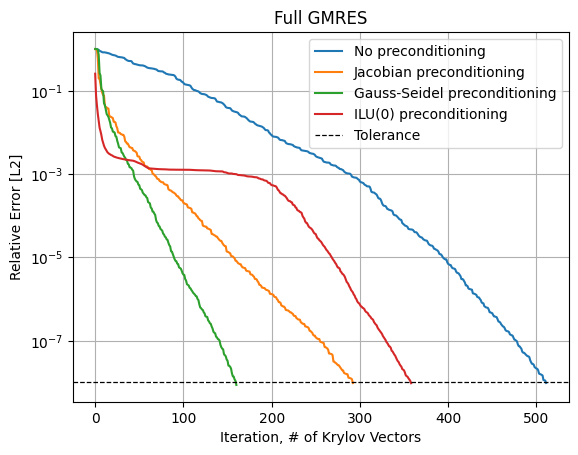

No preconditioning took: 512 Krylov Vectors
Jacobian preconditioning took: 293 Krylov Vectors
Gauss-Seidel preconditioning took: 161 Krylov Vectors
ILU(0) preconditioning took: 359 Krylov Vectors
Execution times respectively:
[224.5627143383026, 213.13137340545654, 117.86377429962158, 374.5501654148102]


In [8]:
### Plotting Bench Results ###

plt.plot(errorz[0],  label = precond_dict[0])
plt.plot(errorz[1],  label = precond_dict[1])
plt.plot(errorz[2],  label = precond_dict[2])
plt.plot(errorz[3],  label = precond_dict[3])
plt.axhline(y = 1e-8, linestyle="dashed", color="k", label = "Tolerance", linewidth=0.9)
plt.legend(loc="upper right")
plt.yscale("log")
plt.xlabel("Iteration, # of Krylov Vectors")
plt.title("Full GMRES")
plt.ylabel("Relative Error [L2]")
plt.grid()
#plt.savefig("FullGMRES.jpeg", dpi=200)
plt.show()
print(precond_dict[0], "took:", len(errorz[0]), "Krylov Vectors")
print(precond_dict[1], "took:", len(errorz[1]), "Krylov Vectors")
print(precond_dict[2], "took:", len(errorz[2]), "Krylov Vectors")
print(precond_dict[3], "took:", len(errorz[3]), "Krylov Vectors")
print("Execution times respectively:")
print(times)

In [ ]:
### Checking For Orthogonality of Krylov Vectors ###

_, _, errors2, exec_time, V = GMRES(JM, VM, x0, b, 0, 600, 1e-08, 1)

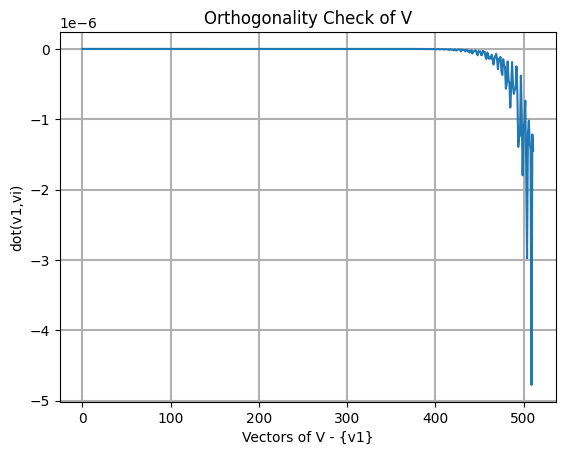

In [10]:
### Plotting Orthogonality Results ###

testarr = np.zeros((V.shape[1]))
for i in range(V.shape[1]-1):
    i += 1
    testarr[i] = dot(V[:,0], V[:,i])
plt.plot(testarr)
plt.title("Orthogonality Check of V")
plt.xlabel("Vectors of V - {v1}")
plt.ylabel("dot(v1,vi)")
plt.grid(lw=1.5)
#plt.savefig("OrthogonalityCheck.jpg", dpi=200)